In [19]:
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [20]:
%matplotlib inline
 
import imageio
import os
import argparse
from glob import glob
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
from pathlib import Path
import sys
import math
 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
 
import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers, losses, metrics, regularizers, optimizers, initializers
from tensorflow.keras.utils import plot_model
 
# Default paths.
SCRIPT_PATH = Path('.')
EXPERIMENT_ID = 'EXP_1'
MODEL_SAVE_PATH = SCRIPT_PATH / EXPERIMENT_ID
IMG_SAVE_PATH = MODEL_SAVE_PATH / 'generated_img'
IMG_SAVE_PATH.mkdir(parents=True, exist_ok=True)
SUMMARY_SAVE_PATH = MODEL_SAVE_PATH / 'summaries' / 'train'
 
DEFAULT_H5_PATH = SCRIPT_PATH / 'h5-output'
 
DEFAULT_LEARNING_RATE = 1e-4
DEFAULT_BATCH_SIZE = 256
DEFAULT_SAVE_PERIOD = 15
DEFAULT_NUM_EPOCH = 500
N_CRITIC = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE
 
noise_dim = 100
num_examples_to_generate = 16

In [21]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [22]:
NUM_DATA = train_images.shape[0]
train_images = train_images.reshape(NUM_DATA, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [23]:
DEFAULT_STEPS_PER_EPOCH = math.ceil(NUM_DATA/float(DEFAULT_BATCH_SIZE))
DEFAULT_NUM_STEPS = DEFAULT_NUM_EPOCH*DEFAULT_STEPS_PER_EPOCH

In [24]:
args = None
 
parser = argparse.ArgumentParser()
parser.add_argument('--h5-dir', type=Path, dest='h5_dir',
                        default=DEFAULT_H5_PATH,
                        help='Directory of h5 files.')
parser.add_argument('--num-train-steps', type=int,
                        dest='num_train_steps',
                        default=DEFAULT_NUM_STEPS,
                        help='The number of times the train iteration is performed')
parser.add_argument('--learning-rate', type=float,
                        dest='learning_rate',
                        default=DEFAULT_LEARNING_RATE,
                        help='How large a learning rate to use when training.')
parser.add_argument('--batch-size', type=int,
                        dest='batch_size',
                        default=DEFAULT_BATCH_SIZE,
                        help='How many images to train on at a time.')
parser.add_argument('--save-period', type=int,
                        dest='save_period',
                        default=DEFAULT_SAVE_PERIOD,
                        help='How many steps to save the checkpoint file.')
parser.add_argument('--steps-per-epoch', type=int,
                        dest='steps_per_epoch',
                        default=DEFAULT_STEPS_PER_EPOCH,
                        help='How many steps per epoch.')
args = parser.parse_args('')

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(NUM_DATA).batch(args.batch_size).prefetch(AUTOTUNE)

In [26]:
def make_generator_model():
    model = tf.keras.Sequential(name='generator')
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
 
    model.add(layers.Reshape((7, 7, 256)))
 
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
 
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
 
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) 
 
    return model

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 7, 7, 128)         0 

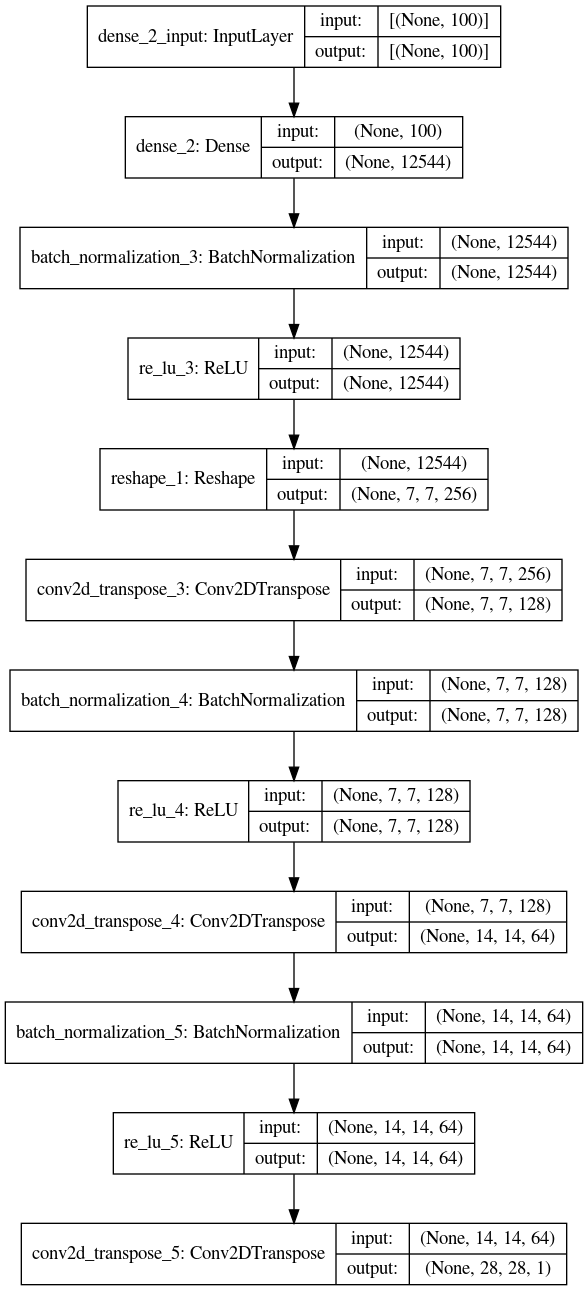

In [27]:
generator = make_generator_model()
generator.summary()
plot_model(generator, to_file=MODEL_SAVE_PATH / "generator.png", show_shapes=True)

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='discriminator')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
 
    return model

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)            

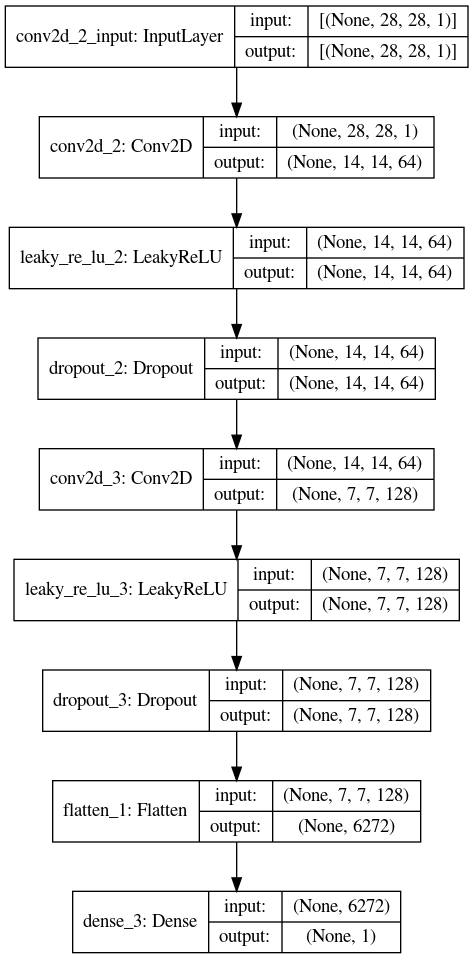

In [29]:
discriminator = make_discriminator_model()
discriminator.summary()
plot_model(discriminator, to_file=MODEL_SAVE_PATH / "discriminator.png", show_shapes=True)

In [30]:
def discriminator_loss(real_output, fake_output):
    real_loss = - tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return real_loss+fake_loss
 
def generator_loss(fake_output):
    fake_loss = - tf.reduce_mean(fake_output)
    return fake_loss

In [31]:
class Checkpoint:
    """Enhanced "tf.train.Checkpoint"."""
 
    def __init__(self,
                 directory,  # for "tf.train.CheckpointManager"
                 max_to_keep=3,
                 keep_checkpoint_every_n_hours=None,
                 **checkpoint_kwargs,  # for "tf.train.Checkpoint"
                 ):
        self.checkpoint = tf.train.Checkpoint(**checkpoint_kwargs)
        self.manager = tf.train.CheckpointManager(self.checkpoint, directory, max_to_keep, keep_checkpoint_every_n_hours)
 
    def restore(self, save_path=None):
        save_path = self.manager.latest_checkpoint if save_path is None else save_path
        if save_path:
            status = self.checkpoint.restore(save_path)
            status.assert_existing_objects_matched()
            print(f"Restored from {save_path}")
        else:
            print("Initializing from scratch.")
            save_path = self.save()
            print("Saved initial checkpoint: {}".format(save_path))
 
    def save(self, file_prefix_or_checkpoint_number=None):
        if isinstance(file_prefix_or_checkpoint_number, str):
            return self.checkpoint.save(file_prefix_or_checkpoint_number)
        else:
            return self.manager.save(checkpoint_number=file_prefix_or_checkpoint_number)
 
    def __getattr__(self, attr):
        if hasattr(self.checkpoint, attr):
            return getattr(self.checkpoint, attr)
        elif hasattr(self.manager, attr):
            return getattr(self.manager, attr)
        else:
            self.__getattribute__(attr)  # this will raise an exception

In [64]:
class WGAN_GP(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
 
        self.noise = tf.keras.Input(shape = (noise_dim,), name='noise')
        self.image = tf.keras.Input(shape = (28, 28, 1), name='image')
        self.generator = generator
        self.discriminator = discriminator
 
        self.fake_output, self.real_output = self.call([self.noise, self.image])
        self.model = Model(inputs=[self.noise, self.image], outputs=[self.fake_output, self.real_output], name='WGAN_GP')

        self.disc_loss = tf.Variable(0.0)
        self.gen_loss = tf.Variable(0.0)
 
    def compile(self, g_optimizer, d_optimizer):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
 
    def call(self, inputs, training=True):
        noise, image = inputs
        fake_output = self.discriminator(self.generator(noise, training=training), training=training)
        real_output = self.discriminator(image, training=training)
        return fake_output, real_output

    def gradient_penalty(self, batch_size, images, generated_images):
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = alpha*images + (1-alpha)*generated_images

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(diff)
            # 1. Get the critic output for this interpolated image.
            pred = self.discriminator(diff)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, diff)
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
 
    @tf.function
    def train_step(self, inputs):
        
        batch_size = tf.shape(inputs)[0]
        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as disc_tape:

            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            real_output = self.discriminator(inputs, training=True)

            disc_loss = discriminator_loss(real_output, fake_output) + self.gradient_penalty(batch_size, inputs, generated_images)
        
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.disc_loss.assign(disc_loss)

        if self.d_optimizer.iterations % N_CRITIC == 0:

            noise = tf.random.normal([batch_size, noise_dim])
            
            with tf.GradientTape() as tape:
                fake_output = self.discriminator(self.generator(noise, training=True), training=True)
                gen_loss = generator_loss(fake_output)

            gradients_of_generator = tape.gradient(gen_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            self.gen_loss.assign(gen_loss)

        return {'gen_loss': self.gen_loss.value(), 'disc_loss': self.disc_loss.value()}

In [65]:
NOISE = tf.random.stateless_normal([num_examples_to_generate, noise_dim], seed=(234, 345), dtype=tf.float32)
 
def generate_and_save_images(model, step):
 
  predictions = model(NOISE, training=False)
 
  plt.figure(figsize=(4,4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.suptitle(f'Step: {step:08d}')
  plt.subplots_adjust(top=0.9)
  plt.savefig(IMG_SAVE_PATH / f'image_at_step_{step:08d}.png')
  plt.show()

In [66]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, ckpt, save_epoch):
        super().__init__()
        self.ckpt = ckpt
        self.save_epoch = save_epoch
    
    def on_train_begin(self, logs=None):
        self.epoch = int(self.ckpt.epoch)
        self.step = self.epoch*args.steps_per_epoch
 
    def on_train_batch_begin(self, batch, logs=None):
        self.step += 1
        
    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        with train_summary_writer.as_default():
            for key, value in logs.items():
                tf.summary.scalar(key, value, step=self.step)
 
        if self.step % (args.num_train_steps//150) == 0: # args.save_period
            display.clear_output(wait=True)
            generate_and_save_images(self.model.generator, self.step)
        
    def on_epoch_begin(self, epoch, logs=None):
        self.ckpt.epoch.assign_add(1)
        self.epoch += 1
    
    def on_epoch_end(self, epoch, logs=None):
        if self.epoch % self.save_epoch == 0:
            save_path = self.ckpt.save()
            print("Saved checkpoint for epoch {}: {}".format(self.epoch, save_path))
 
    def on_train_end(self, logs=None):
        save_path = self.ckpt.save()
        print("Saved checkpoint for epoch {}: {}".format(self.epoch, save_path))

In [67]:
train_summary_writer = tf.summary.create_file_writer(str(SUMMARY_SAVE_PATH))

In [68]:
LOG_DIR = './EXP_1/summaries/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
    )
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://0f0ba373cc6f.ngrok.io


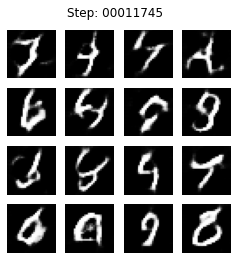

235/235 [==============================] - 9s 35ms/step - gen_loss: -6.8342 - disc_loss: -2.0216
Epoch 51/500
108/235 [============>.................] - ETA: 4s - gen_loss: -1.8189 - disc_loss: -2.6469- ETA: 6s - gen_loss: 

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(args.learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(args.learning_rate)
#generator_optimizer = tf.keras.optimizers.RMSprop(args.learning_rate)
#discriminator_optimizer = tf.keras.optimizers.RMSprop(args.learning_rate)

ckpt = Checkpoint(directory=str(MODEL_SAVE_PATH / 'ckpt'), epoch=tf.Variable(0), 
                  generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

my_callback = MyCallback(ckpt, args.save_period)

wgan_gp = WGAN_GP(generator, discriminator)
 
wgan_gp.compile(
    g_optimizer = generator_optimizer,
    d_optimizer = discriminator_optimizer
)
 
wgan_gp.model.summary()
plot_model(wgan_gp.model, to_file=MODEL_SAVE_PATH / "wgan_gp.png", show_shapes=True)

print('Start learning!')

ckpt.restore()
 
wgan_gp.fit(
        train_dataset,
        #steps_per_epoch = args.steps_per_epoch,
        epochs = DEFAULT_NUM_EPOCH,
        callbacks = [my_callback],
        initial_epoch = int(ckpt.epoch),
)
 
print('Learning finished!')

In [ ]:
tf.saved_model.save(wgan.generator, str(MODEL_SAVE_PATH / 'wgan_gp'))
print('wgan_gp.pb file is created successfully!!')

In [ ]:
anim_file = MODEL_SAVE_PATH / 'wgan_gp.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = sorted(IMG_SAVE_PATH.glob('*.png'))
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        #frame = i
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)